In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from BorutaShap import BorutaShap
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
food_data = pd.read_csv('../data/processed_data/diet.csv')
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Miscellaneous,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables
0,0.000030,0.209212,0.094048,0.0,0.932183,0.102107,0.000030,0.172718,0.099611,0.307722,0.020510,0.164290,0.014672,0.073098,0.086036,0.004887,0.161764,0.0,0.093136,0.087701,0.839472,0.118219,0.259702
1,0.140102,0.706896,0.102562,0.0,0.190717,0.462279,0.028297,0.341492,0.288519,0.917774,0.040196,0.278848,0.074529,0.085016,0.000402,0.053821,0.100273,0.0,0.148501,0.207074,0.278154,0.128436,0.611097
2,0.019552,0.275546,0.016821,0.0,0.539036,0.311591,0.027459,0.298529,0.104371,0.412494,0.067004,0.079743,0.024465,0.140397,0.092487,0.111608,0.139696,0.0,0.176586,0.151658,0.743623,0.397735,0.595502
3,0.404646,0.206405,0.034244,0.0,0.330536,0.025393,0.228756,0.266748,0.264876,0.043159,0.043857,0.165409,0.133725,0.202901,0.000453,0.582692,0.030827,0.0,0.137324,0.004308,0.753912,0.232472,0.105695
4,0.263935,0.725172,0.111637,0.0,0.120333,0.125973,0.437713,0.402774,0.689613,0.403340,0.227956,0.210045,0.055471,0.053701,0.233798,0.029236,0.173150,0.0,0.318216,0.043437,0.208668,0.372299,0.271631


In [ ]:
control = pd.read_csv('../data/raw_data/control/regression_targets.csv')
targets = control[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)

In [ ]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [ ]:
comorbidity_data = pd.read_csv('../data/processed_data/icd10_data_scaled.csv')
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]].drop(['Deaths', 'Active', 'Recovered'], axis=1)
comorbidity_data.head()

,code,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,1125,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,1300,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
2,1310,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco
3,1430,0.254980,0.013513,0.057587,0.415203,0.095107,0.118104,0.115927,0.189757,0.101523,0.126320,0.498899,0.433257,0.192121,0.481148,0.150137,0.200390,0.069400,South Africa
4,1520,0.016797,0.000729,0.002674,0.004683,0.006896,0.003377,0.006622,0.016869,0.003148,0.006662,0.014117,0.053596,0.046754,0.032037,0.007470,0.008149,0.004877,Tunisia


In [ ]:
comorbidity_data = comorbidity_data.merge(targets, on='Country', how='inner')

In [ ]:
development_data = pd.read_csv('../data/raw_data/country_development_data.csv')
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,hdi_2016,hdi_2017,hdi_2018,hdi_2019,gdp_2016,gdp_2017,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,0.216783,0.211268,0.208850,0.207815,0.596273,0.703846,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,0.716783,0.711268,0.709735,0.712256,0.630435,0.750000,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,0.638112,0.632042,0.628319,0.628774,0.627329,0.653846,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,0.349650,0.345070,0.338053,0.332149,0.447205,0.596154,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,0.676573,0.672535,0.674336,0.682060,0.698758,0.723077,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [ ]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [ ]:
merged = food_data.merge(comorbidity_data, how='inner', on='Country')
merged = merged.merge(development_data, on='Country', how='inner')
merged = merged.merge(targets, on='Country', how='inner')
merged.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Miscellaneous,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,hdi_2016,hdi_2017,hdi_2018,hdi_2019,gdp_2016,gdp_2017,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature,Deaths,Confirmed,Active,Recovered
0,0.000030,0.209212,0.094048,0.0,0.932183,0.102107,0.000030,0.172718,0.099611,0.307722,0.020510,0.164290,0.014672,0.073098,0.086036,0.004887,0.161764,0.0,0.093136,0.087701,0.839472,0.118219,0.259702,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,0.216783,0.211268,0.208850,0.207815,0.596273,0.703846,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820,0.006186,0.142134,0.012574,0.123374
1,0.140102,0.706896,0.102562,0.0,0.190717,0.462279,0.028297,0.341492,0.288519,0.917774,0.040196,0.278848,0.074529,0.085016,0.000402,0.053821,0.100273,0.0,0.148501,0.207074,0.278154,0.128436,0.611097,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,0.716783,0.711268,0.709735,0.712256,0.630435,0.750000,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493,0.050951,2.967301,1.123714,1.792636
2,0.019552,0.275546,0.016821,0.0,0.539036,0.311591,0.027459,0.298529,0.104371,0.412494,0.067004,0.079743,0.024465,0.140397,0.092487,0.111608,0.139696,0.0,0.176586,0.151658,0.743623,0.397735,0.595502,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,0.638112,0.632042,0.628319,0.628774,0.627329,0.653846,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447,0.006558,0.244897,0.070767,0.167572
3,0.404646,0.206405,0.034244,0.0,0.330536,0.025393,0.228756,0.266748,0.264876,0.043159,0.043857,0.165409,0.133725,0.202901,0.000453,0.582692,0.030827,0.0,0.137324,0.004308,0.753912,0.232472,0.105695,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,0.349650,0.345070,0.338053,0.332149,0.447205,0.596154,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425,0.001461,0.061687,0.003419,0.056808
4,0.263935,0.725172,0.111637,0.0,0.120333,0.125973,0.437713,0.402774,0.689613,0.403340,0.227956,0.210045,0.055471,0.053701,0.233798,0.029236,0.173150,0.0,0.318216,0.043437,0.208668,0.372299,0.271631,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,0.676573,0.672535,0.674336,0.682060,0.698758,0.723077,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075,0.007143,0.293878,0.095918,0.190816


In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_all =  merged.columns.drop(['Country'])
features_all = features_all.drop(label_values)
features_food = food_data.columns.drop(label_values)
features_comorbidity = comorbidity_data.columns.drop(label_values)
features_development = development_data.columns.drop(label_values)

In [ ]:
features_food = features_food.drop(['Country'])
features_comorbidity = features_comorbidity.drop(['Country', 'code'])
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])
features_all = features_all.drop(['WHO code', 'FAO code'])

In [ ]:
X_food = food_data[features_food]
Y_food = food_data[label_values]
X_comorbidity = comorbidity_data[features_comorbidity]
Y_comorbidity = comorbidity_data[label_values]
X_development = development_data[features_development]
Y_development = development_data[label_values]
X_all = merged[features_all]
Y_all = merged[label_values]

In [ ]:
selected_features_food = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_food.csv')
selected_features_food = selected_features_food['selected_features']
selected_features_comorbidity = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_comorbidity.csv')
selected_features_comorbidity = selected_features_comorbidity['selected_features']
selected_features_development = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_development.csv')
selected_features_development = selected_features_development['selected_features']
selected_features_all = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_all.csv')
selected_features_all = selected_features_all['selected_features']

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=LeaveOneOut())
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_absolute_error').mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_median_absolute_error').mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_squared_error').mean()
  scores['r2'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='r2').mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut())
  return scores, predictions

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250]
}

In [ ]:
all_params, all_score = hyper_parameter_search(X_all[selected_features_all], Y_all['Deaths'], PARAMS)

[17:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {all_params}')
print(f'score: {all_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100}
score: -0.02566644039427269


In [ ]:
xgb_all = XGBRegressor(gamma = all_params['gamma'],
                       learning_rate = all_params['learning_rate'],
                       max_depth = all_params['max_depth'],
                       min_child_weight = all_params['min_child_weight'],
                       n_estimators = all_params['n_estimators'])

In [ ]:
scores_all, predictions_all = cross_validation_predictions(xgb_all, X_all[selected_features_all],
                                                             Y_all['Deaths'])

[23:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
scores_all

{'neg_mean_absolute_error': -0.027719058245331676,
 'neg_mean_squared_error': -0.0012325747951636992,
 'neg_median_absolute_error': -0.023621876078627313,
 'r2': 0.48739988979773147}

In [ ]:
abs_difs_all = np.abs(predictions_all - Y_all['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_all)):
  node = {}
  node['predicted'] = predictions_all[i]
  node['actual'] = Y_all['Deaths'].values[i]
  node['error'] = abs_difs_all[i]
  node['country'] = merged.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

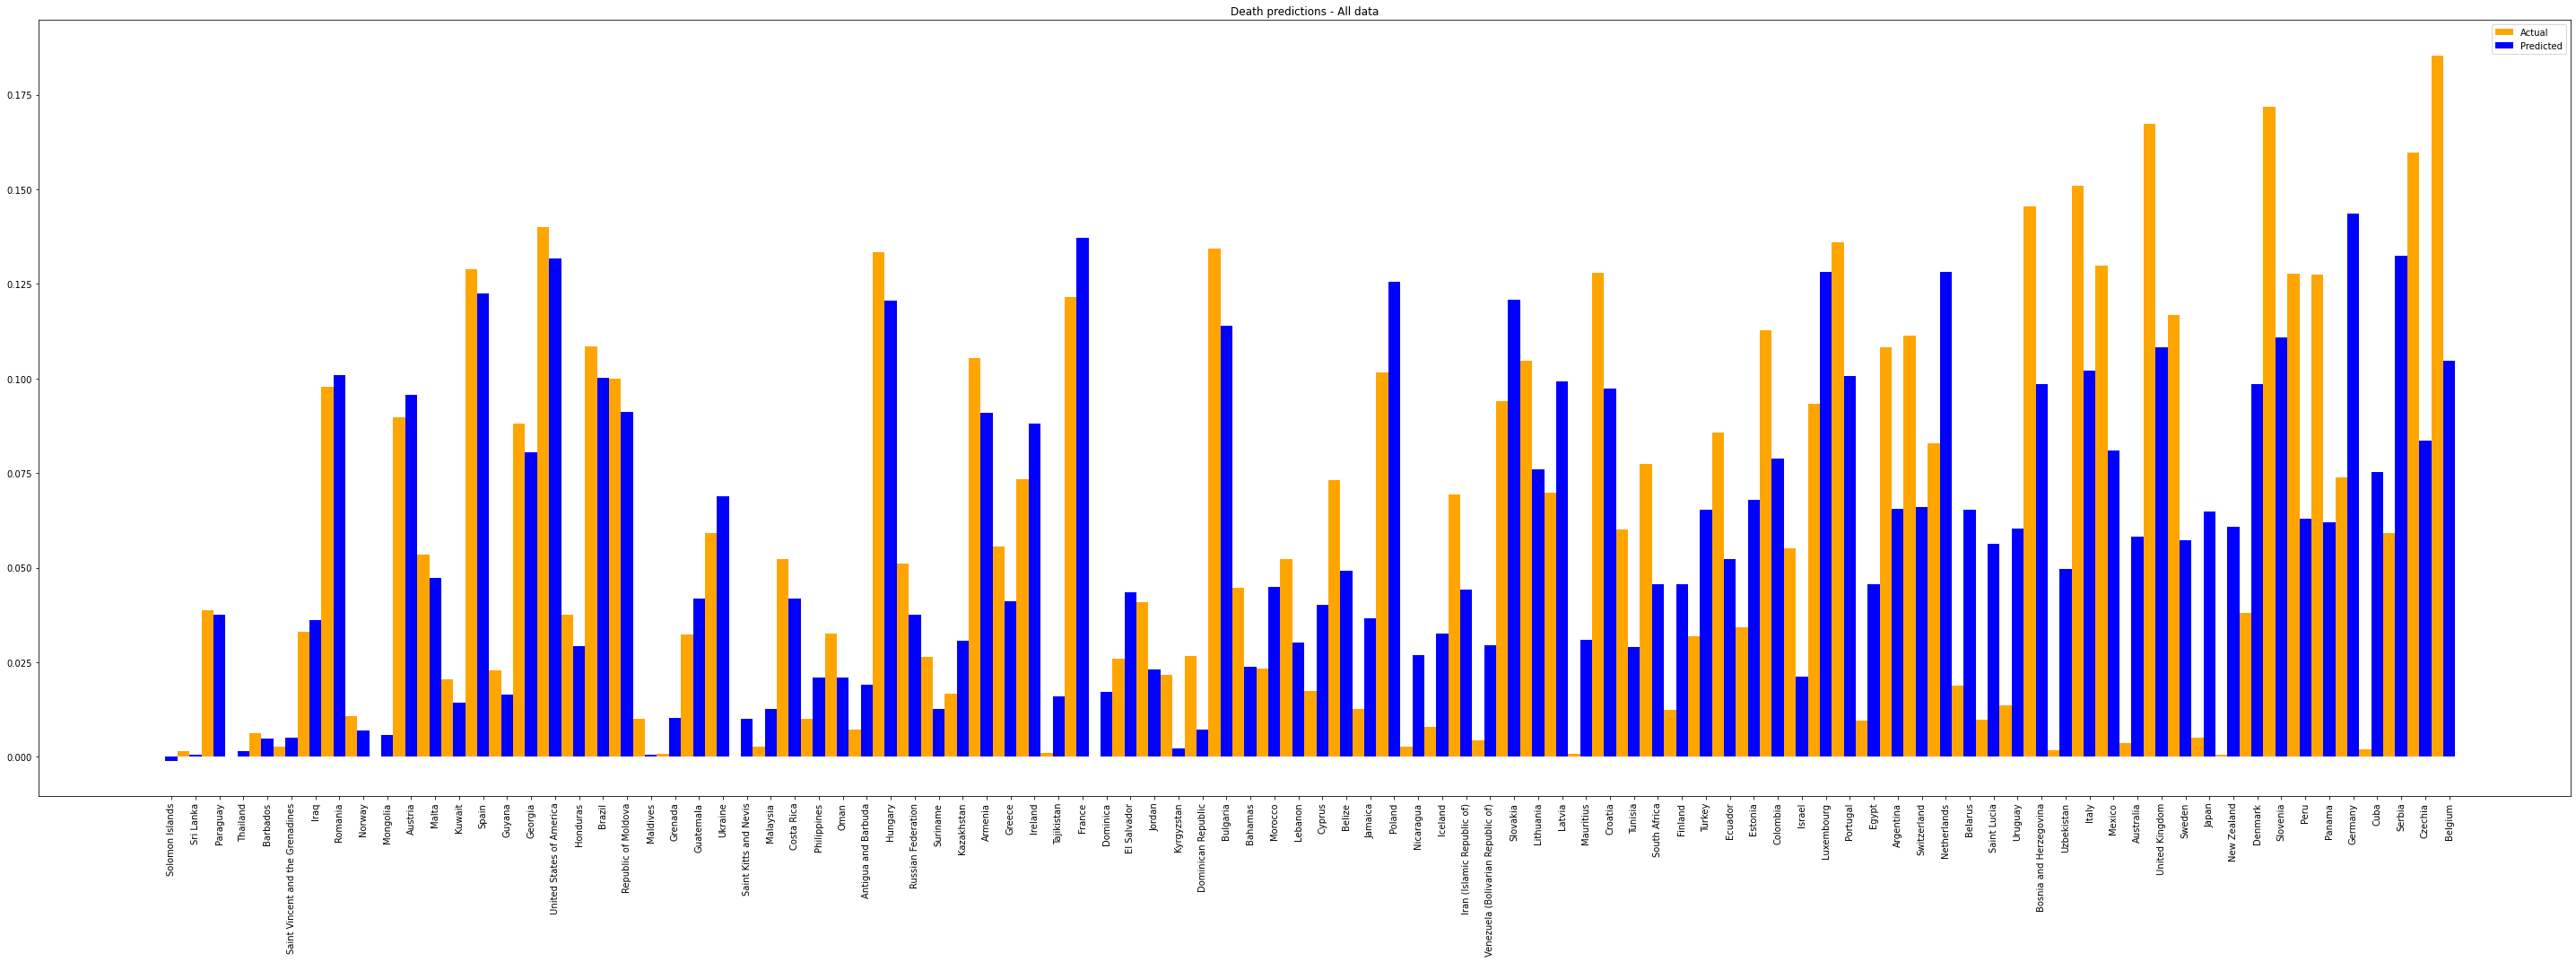

In [ ]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.legend(['Actual', 'Predicted'])
plt.title('Death predictions - All data')
plt.tight_layout()

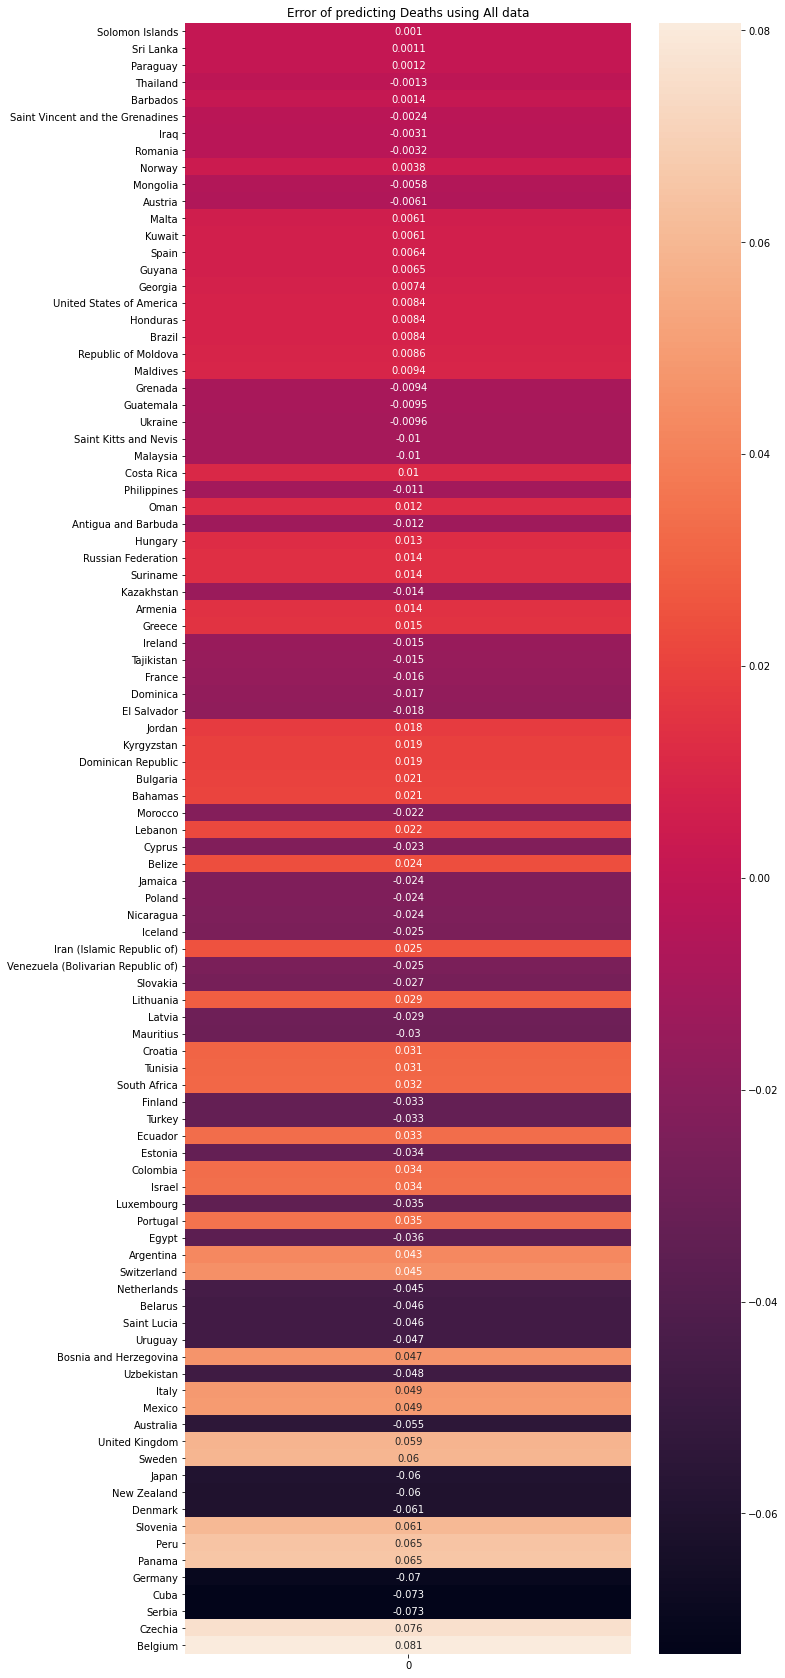

In [ ]:
errors_all = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_all = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_all, annot=True, yticklabels=countries_all)
plt.title("Error of predicting Deaths using All data")

In [ ]:
selected_features_food = selected_features_food.tolist()
selected_features_food.append('Country')
selected_features_development = selected_features_development.tolist()
selected_features_development.append('Country')
selected_features_comorbidity = selected_features_comorbidity.tolist()
selected_features_comorbidity.append('Country')

In [ ]:
data_combined_features = merged[selected_features_food]
data_combined_features = data_combined_features.merge(merged[selected_features_comorbidity], on='Country', how='inner')
data_combined_features = data_combined_features.merge(merged[selected_features_development], on='Country', how='inner')
data_combined_features

,"Fish, Seafood",Alcoholic Beverages,Eggs,Milk - Excluding Butter,Country,Neoplasms,Mental and behavioural disorders,External causes of morbidity and mortality,Diseases of the musculoskeletal system and connective tissue,Obesity,Population,Max Latitude,Max Longitude,Annual Average Temperature
0,0.437713,0.263935,0.125973,0.403340,Antigua and Barbuda,0.000226,0.000081,0.000025,0.000692,0.379391,0.000031,0.420557,0.312344,0.952521
1,0.049406,0.226894,0.582008,0.380750,Argentina,0.090676,0.019168,0.127486,0.076196,0.599532,0.032320,0.073068,0.335135,0.696697
2,0.038342,0.033432,0.438596,0.546411,Armenia,0.014712,0.000247,0.019942,0.008761,0.421546,0.002069,0.627715,0.620419,0.564674
3,0.150230,0.319190,0.287462,0.519809,Australia,0.064172,0.067131,0.040055,0.088339,0.644028,0.018327,0.183417,0.965855,0.848765
4,0.090886,0.484355,0.529942,0.561658,Austria,0.029609,0.015780,0.013360,0.024360,0.444965,0.006318,0.695595,0.536621,0.533885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.125222,0.373535,0.414974,0.533799,United Kingdom,0.234246,0.346003,0.050102,0.286198,0.622951,0.047853,0.799701,0.694087,0.569972
92,0.120671,0.315525,0.515680,0.566007,United States of America,0.850558,1.000000,1.000000,0.865323,0.805621,0.235197,0.892377,0.999374,0.573641
93,0.071126,0.203492,0.478290,0.576810,Uruguay,0.011801,0.007026,0.013990,0.020377,0.608899,0.002479,0.000000,0.336700,0.754617
94,0.013758,0.073024,0.251918,0.599785,Uzbekistan,0.018036,0.000258,0.068799,0.012711,0.290398,0.024331,0.625341,0.695965,0.662754


In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200]
}

In [ ]:
combined_params, combined_score = hyper_parameter_search(data_combined_features[data_combined_features.columns.drop(['Country'])], 
                                                         Y_all['Deaths'], PARAMS)

[17:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {combined_params}')
print(f'score: {combined_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150}
score: -0.03253589350638102


In [ ]:
xgb_combined = XGBRegressor(gamma = combined_params['gamma'], 
                            learning_rate = combined_params['learning_rate'],
                            max_depth = combined_params['max_depth'], 
                            min_child_weight = combined_params['min_child_weight'],
                            n_estimators = combined_params['n_estimators'])

In [ ]:
scores_combined, predictions_combined = cross_validation_predictions(xgb_combined,
                                                                     data_combined_features[data_combined_features.columns.drop(['Country'])],
                                                             Y_all['Deaths'])

[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
scores_combined

{'neg_mean_absolute_error': -0.0334157336927191,
 'neg_mean_squared_error': -0.0018442453482353112,
 'neg_median_absolute_error': -0.02682524356712805,
 'r2': 0.23612745999000825}

In [ ]:
abs_difs_combined = np.abs(predictions_combined - Y_all['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_combined)):
  node = {}
  node['predicted'] = predictions_combined[i]
  node['actual'] = Y_all['Deaths'].values[i]
  node['error'] = abs_difs_combined[i]
  node['country'] = data_combined_features.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

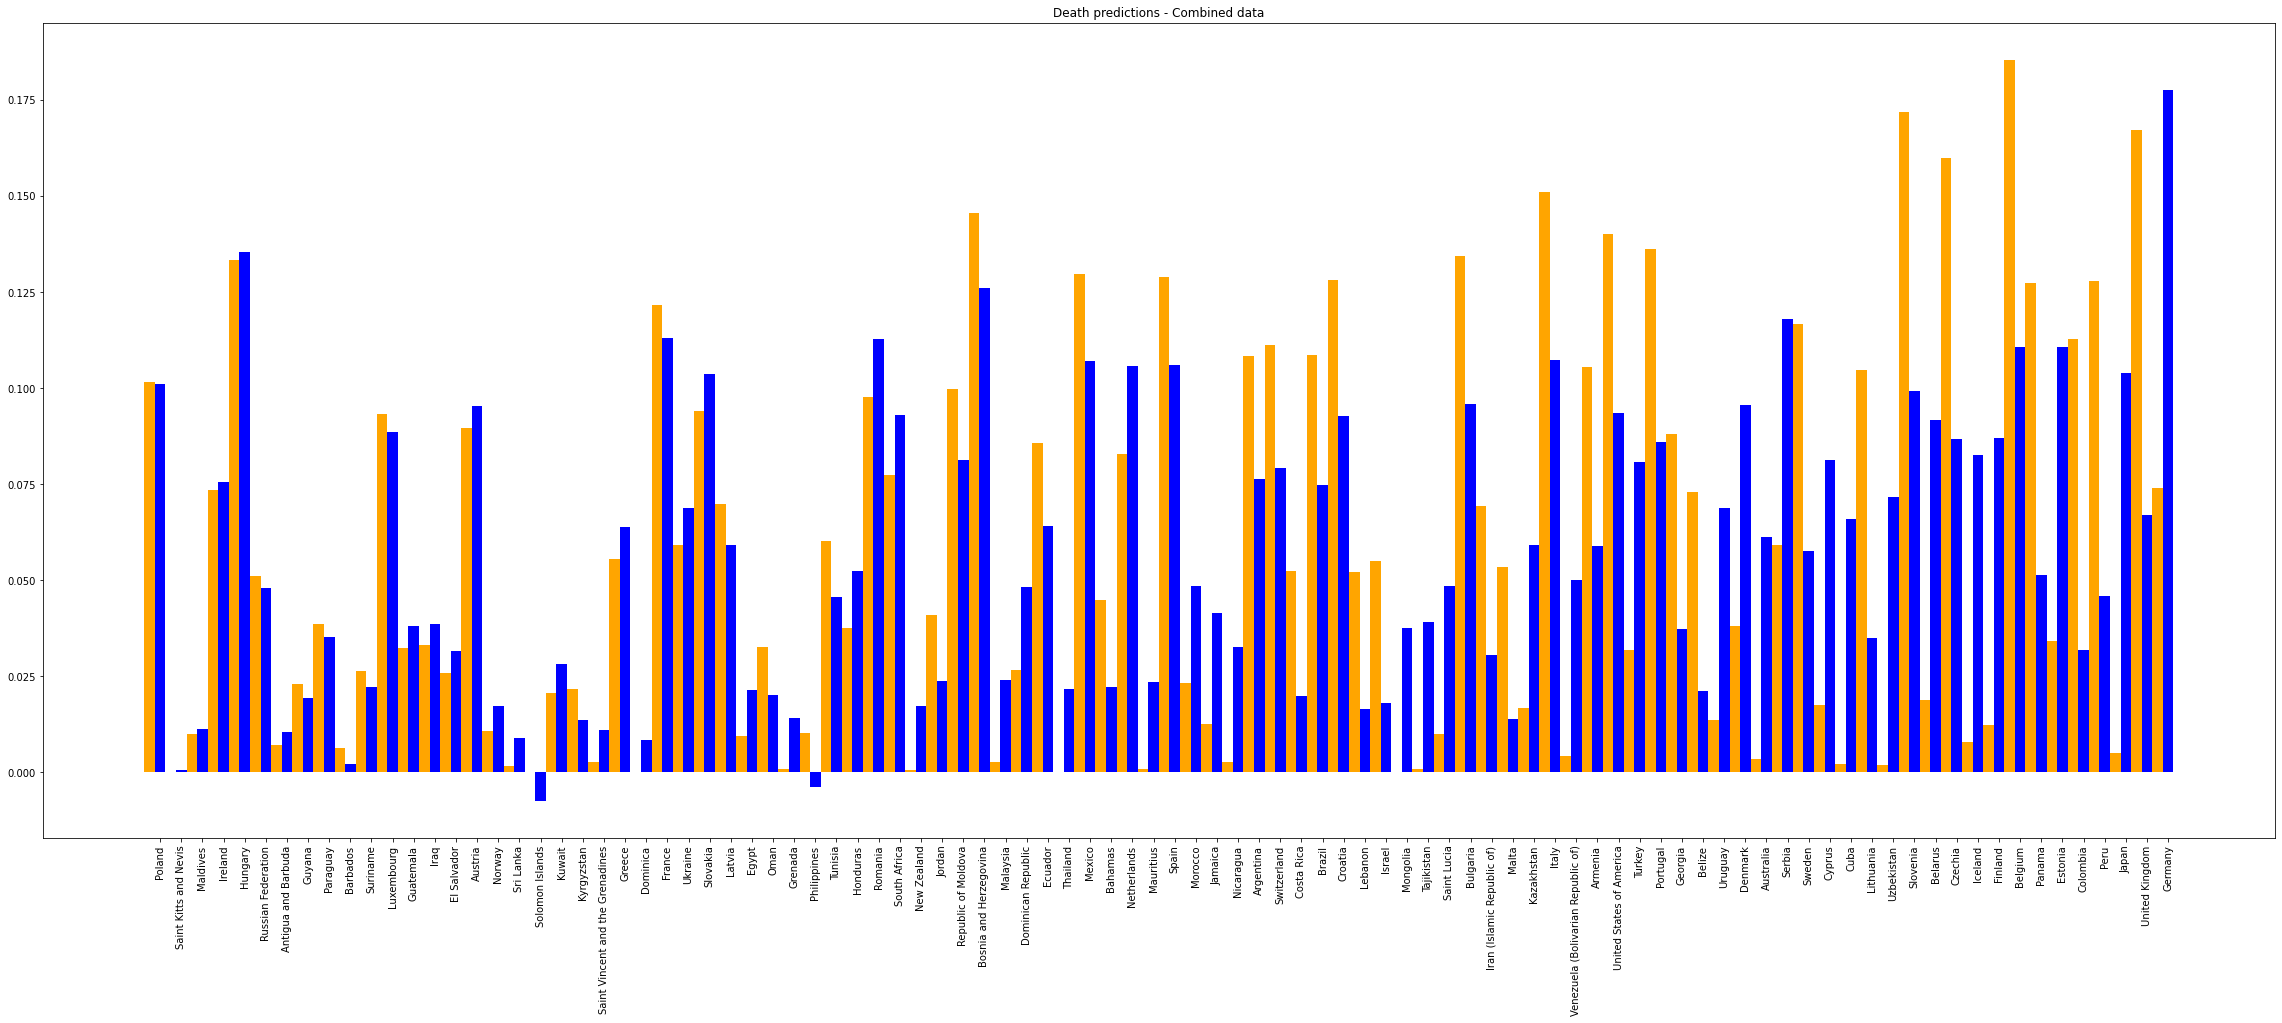

In [ ]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Combined data')

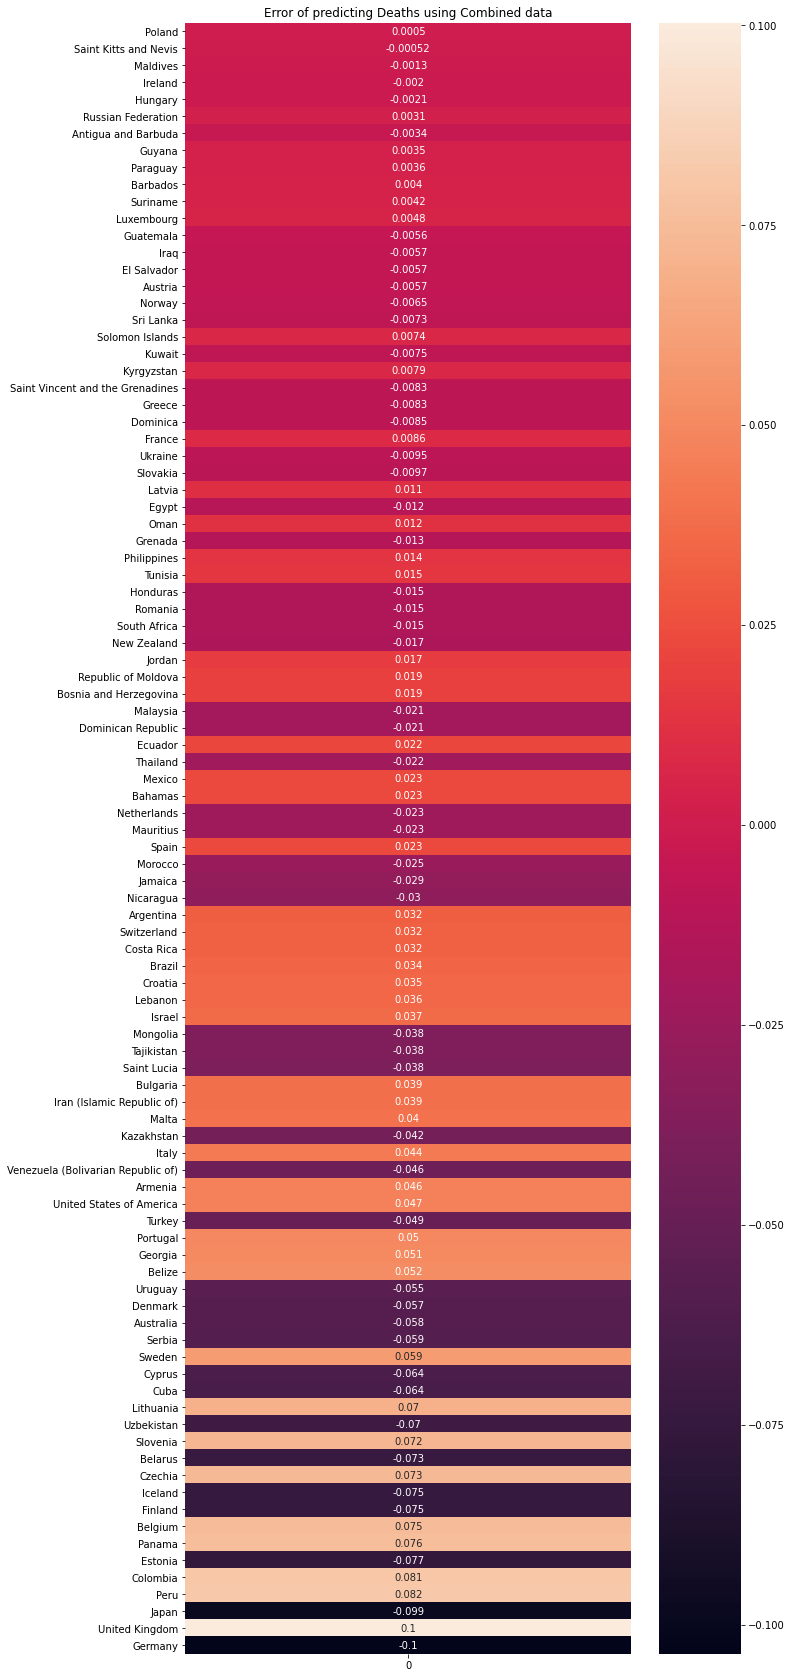

In [ ]:
errors_combined = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_combined = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_combined, annot=True, yticklabels=countries_combined)
plt.title("Error of predicting Deaths using Combined data")

In [ ]:
ordered_values = []
for i in range(len(abs_difs_combined)):
  node = {}
  node['predicted combined'] = predictions_combined[i]
  node['predicted all'] = predictions_all[i]
  node['error'] = np.abs(predictions_all[i] - predictions_combined[i])
  node['country'] = data_combined_features.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

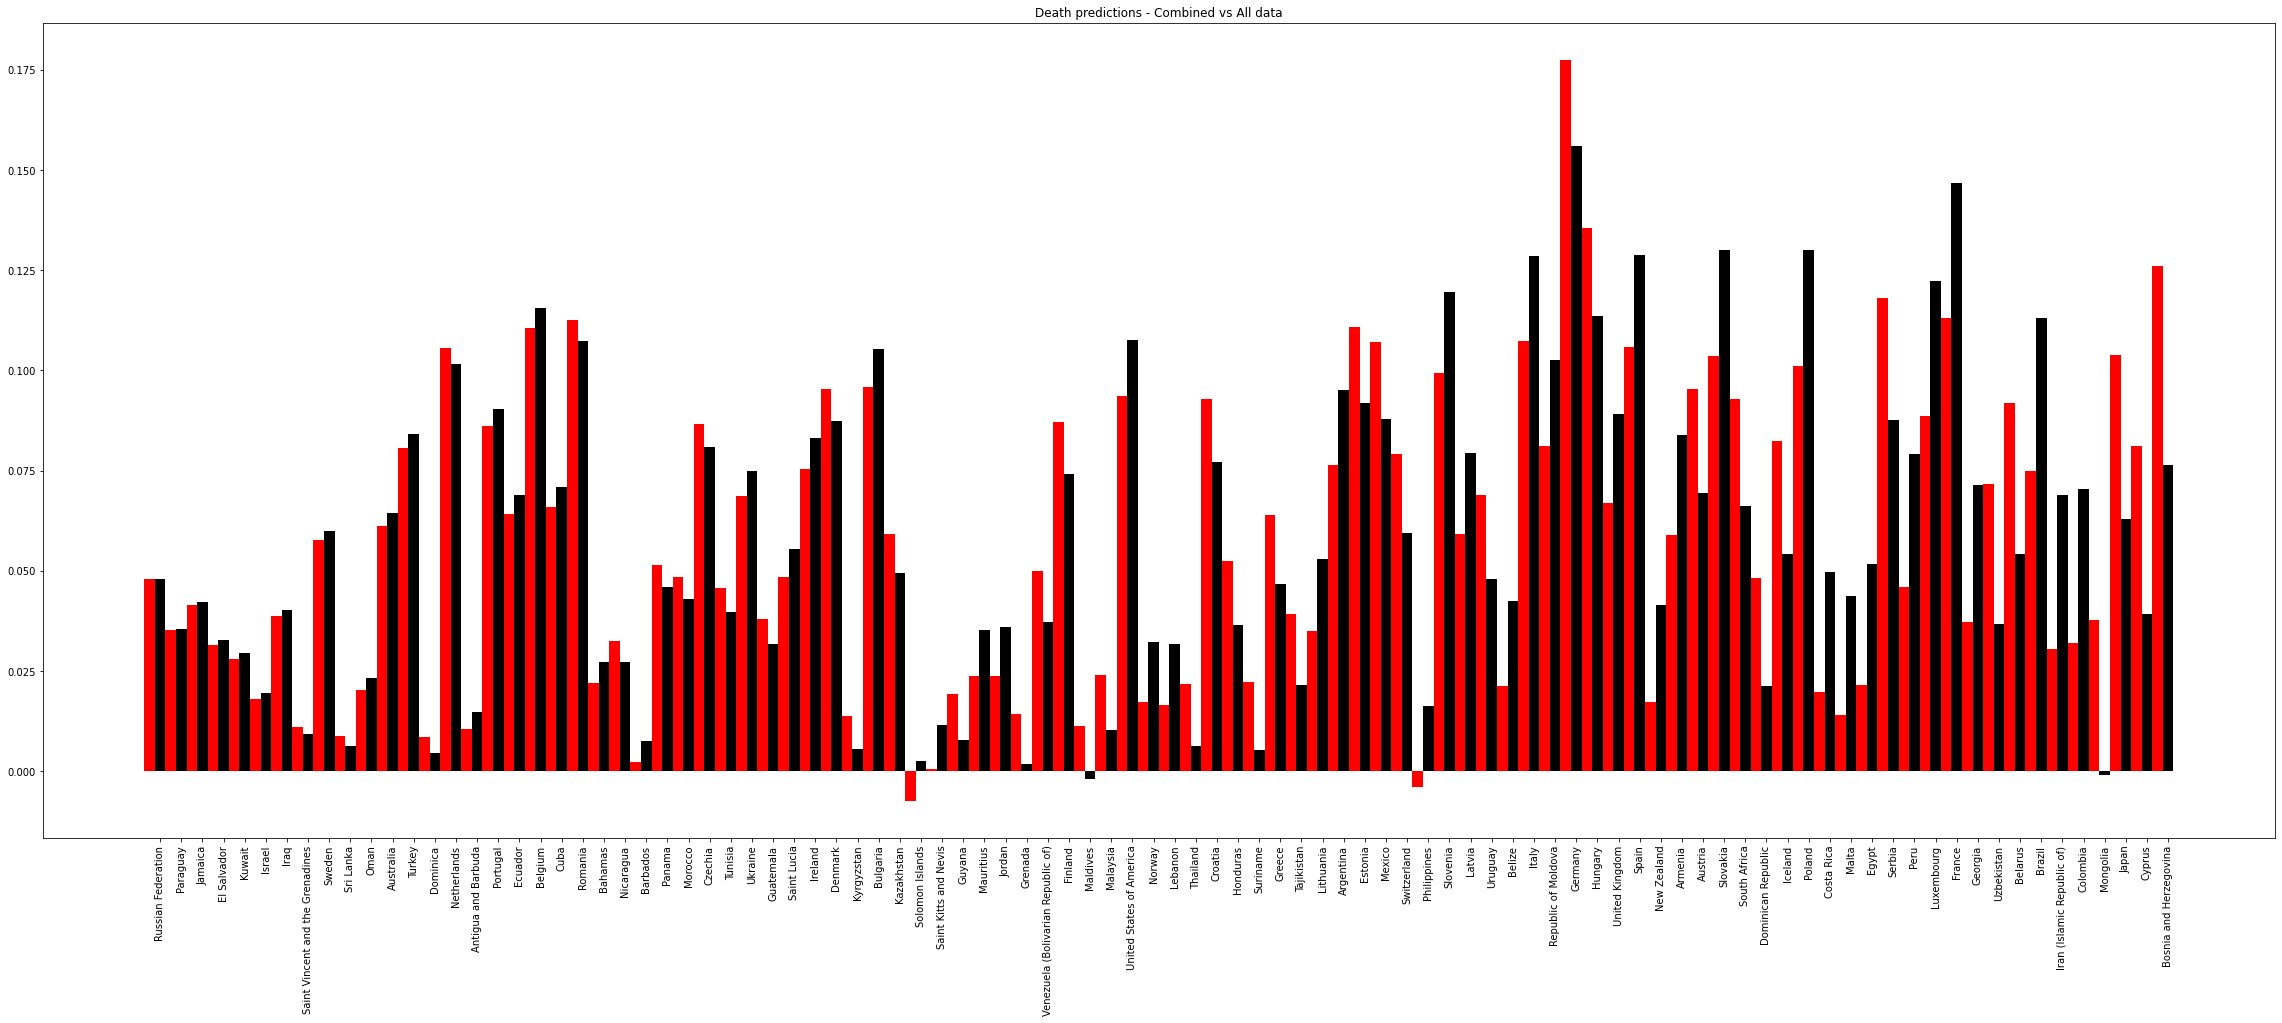

In [ ]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['predicted combined'], width=0.5, color='red', align='center', label='Predicted Combined')
  plt.bar(x[i], elem['predicted all'], color='black', label='Predicted All', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Combined vs All data')

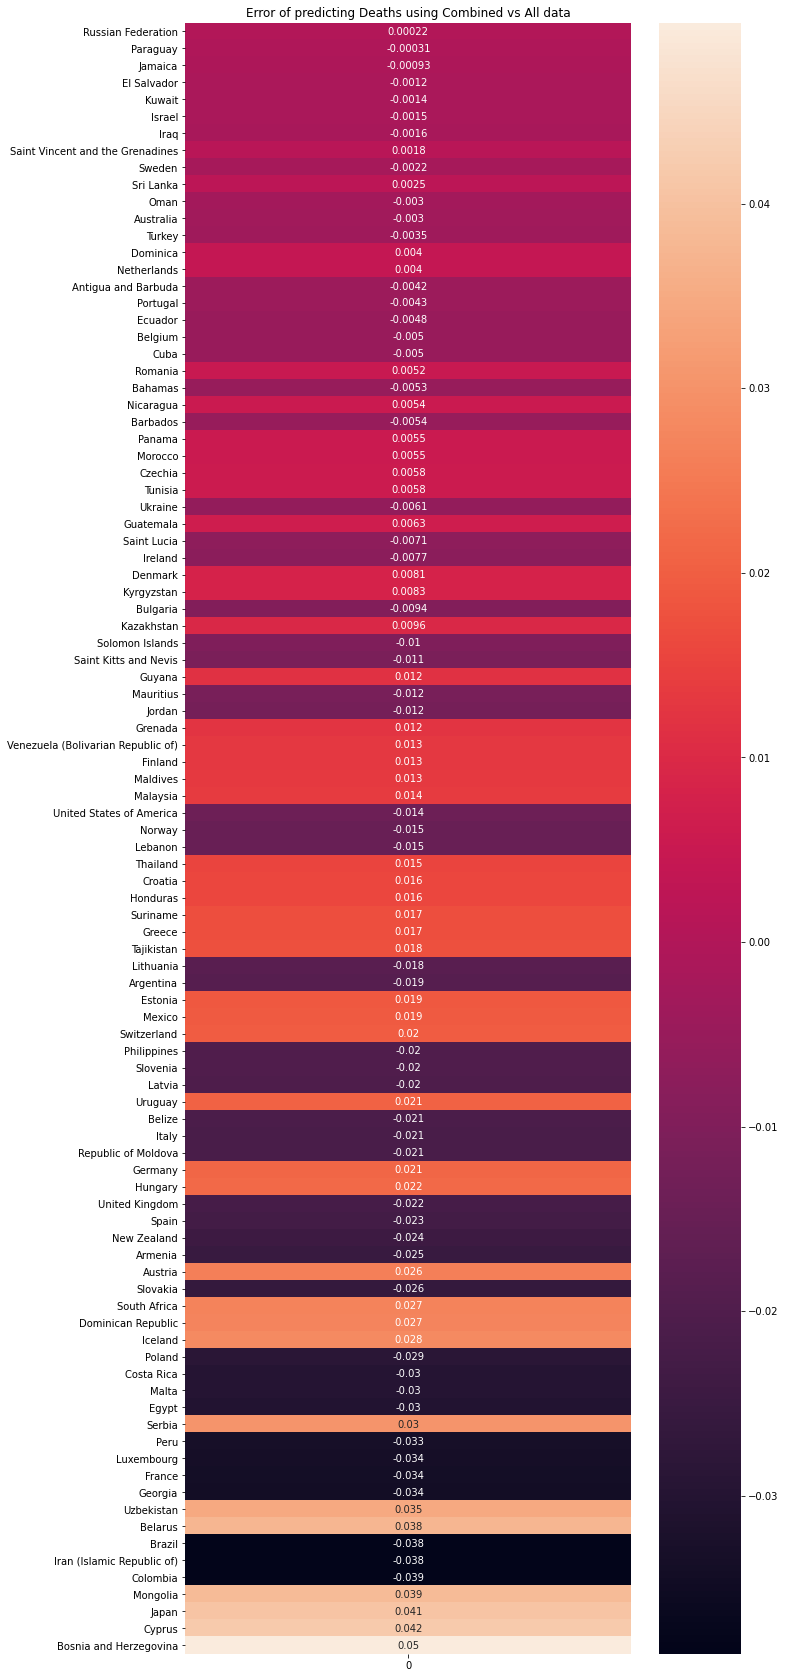

In [ ]:
errors_combined = [[val['predicted combined'] - val['predicted all']] for val in ordered_values]
countries_combined = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_combined, annot=True, yticklabels=countries_combined)
plt.title("Error of predicting Deaths using Combined vs All data")